# Set up and retrieve data

In [2]:
library(dplyr)
library(poLCA)
library(ggplot2)
#library(ggparallel)
#library(igraph)
library(tidyr)
library(knitr)
library(bigrquery)
library(stringr)
#library(data.table)
library(sjmisc)
library(mlogit)

In [16]:
bq_auth(use_oob = TRUE)

In [17]:
PROJECT_ID <- "dcw-data-platform-analysis"

In [18]:
# Testing the model concept with a smaller dataset, consisting of records in the year 2020

sql_query1 <- "
    SELECT *, DATE_DIFF(DELIVERY_DATE, ORDER_DATE, DAY) AS DATE_DIFF,
    EXTRACT(DAYOFWEEK FROM DELIVERY_DATE) AS WEEK_DAY,
    EXTRACT(MONTH FROM DELIVERY_DATE) AS MONTH
    FROM `dcw-data-platform-analysis.Bui.CPCW_DELIVERY`
    WHERE ORDER_DATE >= '2020-01-01'
    AND DELIVERY_CHARGE IS NOT NULL
    AND CSC IS NOT NULL
"
# Eliminate missing data of delivery charges and CSCs
# Sunday is equal to 1, the first day of the week

In [20]:
options(scipen = 20)

In [21]:
# Collect specified data
data_2020 <- bq_table_download(
    bq_project_query(
        PROJECT_ID,
        query = sql_query1
    )
)

In [22]:
save(data_2020, file = "data_2020.rda")

In [23]:
# Basic inspection
head(data_2020)
summary(data_2020)

MA_CODE MA                           PROD_CD PRODUCT_DESC                    
1   87    0087: TV STANDS AND BRACKETS  93013  093013    :  LOG S800BG11X      
2   87    0087: TV STANDS AND BRACKETS 229208  229208    :  LOG L105MDF18      
3 2038    2038: RANGE COOKING TSL      211180  211180    :  RMA PROP110NG FSS/C
4 2047    2047: WASHER DRYERS TSL      510596  510596    :  BOS WVH28424G B    
5 2038    2038: RANGE COOKING TSL      181953  181953    :  RMA CDL110DFF BL/C 
6   87    0087: TV STANDS AND BRACKETS  42660  042660    :  LOG S105BG13       
  BRAND           PLU_RETAIL_PRICE BAND_FIFTY CREDIT_BAND ORDER_STORE
1 LOG: LOGIK        49.99            50        100        4944       
2 LOG: LOGIK        39.99            50        100        4944       
3 RMA: RANGEMASTE 1899.00          1900       2500        4944       
4 BOS: BOSCH       925.00           950       1000        4944       
5 RMA: RANGEMASTE 1999.00          2000       2500        4944       
6 LOG: LOGIK        49.99            50        100        4944       
  ORDER_DATE ⋯ OUTCODE DLC   CSC         SRV_TYPS   VOLUME DELIVERY_CHARGE
1 2020-03-24 ⋯ YO16    74650 Leeds       D          1       0.00000       
2 2020-04-23 ⋯ ML3     74490 Glasgow     D          1       0.00000       
3 2020-04-15 ⋯ N9      74230 Stevenage   D          1      30.00000       
4 2020-04-30 ⋯ KT21    74215 Basingstoke Q          1      40.00000       
5 2020-01-27 ⋯ OX44    74280 Aylesbury   DI         1      33.33333       
6 2020-02-18 ⋯ TW14    74280 Aylesbury   D          1       0.00000       
  CUSTOMER_SEGMENT DATE_DIFF WEEK_DAY MONTH
1  7                9        5        4    
2 NA                3        1        4    
3 NA                1        5        4    
4 NA                1        6        5    
5  6               28        2        2    
6  0                5        1        2

    MA_CODE            MA               PROD_CD       PRODUCT_DESC      
 Min.   :   3.0   Length:1002078     Min.   :    92   Length:1002078    
 1st Qu.: 100.0   Class :character   1st Qu.:195220   Class :character  
 Median : 102.0   Mode  :character   Median :233481   Mode  :character  
 Mean   : 391.5                      Mean   :291724                     
 3rd Qu.: 123.0                      3rd Qu.:265259                     
 Max.   :2048.0                      Max.   :999279                     
                                                                        
    BRAND           PLU_RETAIL_PRICE    BAND_FIFTY        CREDIT_BAND      
 Length:1002078     Min.   :  12.97   Min.   :    50.0   Min.   :   100.0  
 Class :character   1st Qu.: 229.00   1st Qu.:   250.0   1st Qu.:   250.0  
 Mode  :character   Median : 299.99   Median :   300.0   Median :   500.0  
                    Mean   : 382.26   Mean   :   788.7   Mean   :   888.6  
                    3rd Qu.: 429.00 

# Data preparation

In [24]:
# Whether or not a time-slot was selected 
classifier_func_slot <- function(x) {
    sum(ifelse(str_contains(x, "Q"), 1, 0))
}

# Whether or not installation was selected
classifier_func_insta <- function(x) {
    sum(ifelse(str_contains(x, c("G", "I", "J", "K", "L", "M", "N", "P", "R")), 1, 0))
}

# Whether or not disposal was selected
classifier_func_colle <- function(x) {
    sum(ifelse(str_contains(x, c("F", "K", "M", "N", "P", "S")), 1, 0))
}

In [25]:
# Manifest variables
data_2020$INSTALLATION <- sapply(data_2020$SRV_TYPS, FUN = classifier_func_insta)
data_2020$COLLECTION <- sapply(data_2020$SRV_TYPS, FUN = classifier_func_colle)
data_2020$TIME_SLOT <- sapply(data_2020$SRV_TYPS, FUN = classifier_func_slot)
data_2020$WEEKEND_DELV <- ifelse(data_2020$WEEK_DAY %in% c(1,7), 1, 0) # preference of delivery during weekend


data_2020$DELIVERY_CHARGE <- abs(data_2020$DELIVERY_CHARGE) # assume that all negative charges are mistakes
data_2020$NEXT_DAY <- ifelse(data_2020$DATE_DIFF <= 1, 1, 0)
data_2020$DELV_EXTRA <- data_2020$INSTALLATION + data_2020$COLLECTION

In [26]:
# Check the data class and missing values
str(data_2020)

tibble [1,002,078 × 27] (S3: tbl_df/tbl/data.frame)
 $ MA_CODE         : int [1:1002078] 87 87 2038 2047 2038 87 87 87 2038 87 ...
 $ MA              : chr [1:1002078] "0087: TV STANDS AND BRACKETS" "0087: TV STANDS AND BRACKETS" "2038: RANGE COOKING TSL" "2047: WASHER DRYERS TSL" ...
 $ PROD_CD         : num [1:1002078] 93013 229208 211180 510596 181953 ...
 $ PRODUCT_DESC    : chr [1:1002078] "093013    :  LOG S800BG11X" "229208    :  LOG L105MDF18" "211180    :  RMA PROP110NG FSS/C" "510596    :  BOS WVH28424G B" ...
 $ BRAND           : chr [1:1002078] "LOG: LOGIK" "LOG: LOGIK" "RMA: RANGEMASTE" "BOS: BOSCH" ...
 $ PLU_RETAIL_PRICE: num [1:1002078] 50 40 1899 925 1999 ...
 $ BAND_FIFTY      : num [1:1002078] 50 50 1900 950 2000 50 50 50 1450 50 ...
 $ CREDIT_BAND     : num [1:1002078] 100 100 2500 1000 2500 100 100 100 1500 100 ...
 $ ORDER_STORE     : int [1:1002078] 4944 4944 4944 4944 4944 4944 2379 4944 2430 2344 ...
 $ ORDER_DATE      : Date[1:1002078], format: "2020-03-24" "2

In [45]:
# Create a data copy
data_2020$ID <- seq.int(nrow(data_2020))
data_2020_latent <- data_2020 %>%
                    dplyr::select(ID, MA:DELV_EXTRA, -c(PROD_CD, PRODUCT_DESC, SRV_TYPS))

# Change to categorical variables
# Plus 1 as per latent model preparation
data_2020_latent$TIME_SLOT <- as.factor(data_2020_latent$TIME_SLOT + 1)
data_2020_latent$WEEKEND_DELV <- as.factor(data_2020_latent$WEEKEND_DELV + 1)
data_2020_latent$INSTALLATION <- as.factor(data_2020_latent$INSTALLATION + 1)
data_2020_latent$COLLECTION <- as.factor(data_2020_latent$COLLECTION + 1)
data_2020_latent$MA <- as.factor(data_2020_latent$MA)
data_2020_latent$CSC <- as.factor(data_2020_latent$CSC)

In [4]:
# Prep latent class inputs
# Non-covariate
f <- cbind(TIME_SLOT,WEEKEND_DELV,INSTALLATION,COLLECTION) ~ 1

In [43]:
# With CSC covariate
f.csc <- cbind(TIME_SLOT,WEEKEND_DELV,INSTALLATION,COLLECTION) ~ CSC

In [11]:
data_2020_latent <- data_2020 %>%
                    dplyr::select(ID, MA:DELV_EXTRA, -c(PROD_CD, PRODUCT_DESC, SRV_TYPS))

data_2020_latent$TIME_SLOT <- as.factor(data_2020_latent$TIME_SLOT + 1)
data_2020_latent$WEEKEND_DELV <- as.factor(data_2020_latent$WEEKEND_DELV + 1)
data_2020_latent$INSTALLATION <- as.factor(data_2020_latent$INSTALLATION + 1)
data_2020_latent$COLLECTION <- as.factor(data_2020_latent$COLLECTION + 1)
data_2020_latent$MA <- as.factor(data_2020_latent$MA)
data_2020_latent$CSC <- as.factor(data_2020_latent$CSC)

In [36]:
# Save data
save(data_2020, file = "data_2020_processed.rda")

In [3]:
load("data_2020_processed.rda")
load("lc.no.cov3.rda")

# Customer segmentation by latent analysis

> Non-covariate model: Testing latent models

In [29]:
lc.no.cov2 <- poLCA(f, data_2020_latent, nclass=2, maxiter=3000, 
               tol=1e-5,  
               nrep=10, verbose=TRUE, calc.se=TRUE)

save(lc.no.cov2, file = "lc.no.cov2.rda")

Model 1: llik = -1926673 ... best llik = -1926673
Model 2: llik = -1926673 ... best llik = -1926673
Model 3: llik = -1926673 ... best llik = -1926673
Model 4: llik = -1926673 ... best llik = -1926673
Model 5: llik = -1992965 ... best llik = -1926673
Model 6: llik = -1926673 ... best llik = -1926673
Model 7: llik = -1926673 ... best llik = -1926673
Model 8: llik = -1926673 ... best llik = -1926673
Model 9: llik = -1926673 ... best llik = -1926673
Model 10: llik = -1926673 ... best llik = -1926673
Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$TIME_SLOT
           Pr(1)  Pr(2)
class 1:  0.8438 0.1562
class 2:  0.9311 0.0689

$WEEKEND_DELV
           Pr(1)  Pr(2)
class 1:  0.7080 0.2920
class 2:  0.7033 0.2967

$INSTALLATION
           Pr(1)  Pr(2) Pr(3)
class 1:  0.3071 0.6929     0
class 2:  0.9780 0.0220     0

$COLLECTION
           Pr(1)  Pr(2)
class 1:  0.3173 0.6827
class 2:  0.8397 0.1603

Estimated class population shares 
 0.2432

In [13]:
lc.no.cov3 <- poLCA(f, data_2020_latent, nclass=3, maxiter=3000, 
               tol=1e-5,  
               nrep=10, verbose=TRUE, calc.se=TRUE)

save(lc.no.cov3, file = "lc.no.cov3.rda")

Model 1: llik = -1926566 ... best llik = -1926566
Model 2: llik = -1926679 ... best llik = -1926566
Model 3: llik = -1926565 ... best llik = -1926565
Model 4: llik = -1926565 ... best llik = -1926565
Model 5: llik = -1926565 ... best llik = -1926565
Model 6: llik = -1926566 ... best llik = -1926565
Model 7: llik = -1926678 ... best llik = -1926565
Model 8: llik = -1926565 ... best llik = -1926565
Model 9: llik = -1926566 ... best llik = -1926565
Model 10: llik = -1926565 ... best llik = -1926565
Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$TIME_SLOT
           Pr(1)  Pr(2)
class 1:  0.9301 0.0699
class 2:  0.8441 0.1559
class 3:  0.9318 0.0682

$WEEKEND_DELV
           Pr(1)  Pr(2)
class 1:  0.4369 0.5631
class 2:  0.7151 0.2849
class 3:  0.8556 0.1444

$INSTALLATION
           Pr(1)  Pr(2) Pr(3)
class 1:  0.9742 0.0258     0
class 2:  0.3102 0.6897     0
class 3:  0.9807 0.0193     0

$COLLECTION
           Pr(1)  Pr(2)
class 1:  0.8

In [31]:
lc.no.cov4 <- poLCA(f, data_2020_latent, nclass=4, maxiter=3000, 
               tol=1e-5,  
               nrep=10, verbose=TRUE, calc.se=TRUE)

save(lc.no.cov4, file = "lc.no.cov4.rda")

Model 1: llik = -1926564 ... best llik = -1926564
Model 2: llik = -1926561 ... best llik = -1926561
Model 3: llik = -1926561 ... best llik = -1926561
Model 4: llik = -1926564 ... best llik = -1926561
Model 5: llik = -1926568 ... best llik = -1926561
Model 6: llik = -1926564 ... best llik = -1926561
Model 7: llik = -1926564 ... best llik = -1926561
Model 8: llik = -1926566 ... best llik = -1926561
Model 9: llik = -1926566 ... best llik = -1926561
Model 10: llik = -1926565 ... best llik = -1926561
Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$TIME_SLOT
           Pr(1)  Pr(2)
class 1:  0.9673 0.0327
class 2:  0.8455 0.1545
class 3:  0.9296 0.0704
class 4:  0.8304 0.1696

$WEEKEND_DELV
           Pr(1)  Pr(2)
class 1:  0.6799 0.3201
class 2:  0.7175 0.2825
class 3:  0.7648 0.2352
class 4:  0.6733 0.3267

$INSTALLATION
           Pr(1)  Pr(2) Pr(3)
class 1:  0.9849 0.0151     0
class 2:  0.2851 0.7148     0
class 3:  0.9509 0.0491     0
cl

In [33]:
comparison <- data.frame(Model = c("2-class model", "3-class model", "4-class model"),
                        AIC = c(lc.no.cov2$aic, lc.no.cov3$aic, lc.no.cov4$aic),
                        BIC = c(lc.no.cov2$bic, lc.no.cov3$bic, lc.no.cov4$bic),
                        Log_likelihood = c(lc.no.cov2$llik, lc.no.cov3$llik, lc.no.cov4$llik),
                        Likelihood_ratio = c(lc.no.cov2$Gsq, lc.no.cov4$Gsq, lc.no.cov4$Gsq))

comparison

Model         AIC     BIC     Log_likelihood Likelihood_ratio
1 2-class model 3853368 3853498 -1926673       228.097985      
2 3-class model 3853164 3853365 -1926565         4.018337      
3 4-class model 3853168 3853440 -1926561         4.018337

> Profiling the class members

In [14]:
# Among 2~4 class models, 3-class model performed the best (smallest values of BIC and AIC)
probs.start<-lc.no.cov3$probs.start

lc.no.cov3 <- poLCA(f, data_2020_latent, probs.start=probs.start, nclass=3, maxiter=3000, graph=TRUE)

Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$TIME_SLOT
           Pr(1)  Pr(2)
class 1:  0.9301 0.0699
class 2:  0.8441 0.1559
class 3:  0.9318 0.0682

$WEEKEND_DELV
           Pr(1)  Pr(2)
class 1:  0.4369 0.5631
class 2:  0.7151 0.2849
class 3:  0.8556 0.1444

$INSTALLATION
           Pr(1)  Pr(2) Pr(3)
class 1:  0.9742 0.0258     0
class 2:  0.3102 0.6898     0
class 3:  0.9807 0.0193     0

$COLLECTION
           Pr(1)  Pr(2)
class 1:  0.8173 0.1827
class 2:  0.3184 0.6816
class 3:  0.8539 0.1461

Estimated class population shares 
 0.2789 0.2447 0.4763 
 
Predicted class memberships (by modal posterior prob.) 
 0.2371 0.2014 0.5615 
 
Fit for 3 latent classes: 
number of observations: 1002078 
number of estimated parameters: 17 
residual degrees of freedom: 6 
maximum log-likelihood: -1926565 
 
AIC(3): 3853164
BIC(3): 3853365
G^2(3): 12.07772 (Likelihood ratio/deviance statistic) 
X^2(3): 13.62995 (Chi-square goodness of fit) 
 

Model 1: llik = -1992312 ... best llik = -1992312
Model 2: llik = -1926319 ... best llik = -1926319
Model 3: llik = -1988054 ... best llik = -1926319
Model 4: llik = -1980380 ... best llik = -1926319
Model 5: llik = -1946441 ... best llik = -1926319
Model 6: llik = -1989051 ... best llik = -1926319
Model 7: llik = -1944333 ... best llik = -1926319
Model 8: llik = -1989522 ... best llik = -1926319
Model 9: llik = -1988313 ... best llik = -1926319
Model 10: llik = -1991483 ... best llik = -1926319
Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$TIME_SLOT
           Pr(1)  Pr(2)
class 1:  0.9311 0.0689
class 2:  0.8601 0.1399
class 3:  0.9343 0.0657

$WEEKEND_DELV
           Pr(1)  Pr(2)
class 1:  0.8296 0.1704
class 2:  0.7003 0.2997
class 3:  0.6967 0.3033

$INSTALLATION
           Pr(1)  Pr(2) Pr(3)
class 1:  0.8524 0.1476     0
class 2:  0.4989 0.5011     0
class 3:  0.9777 0.0223     0

$COLLECTION
           Pr(1)  Pr(2)
class 1:  0.7

Warning message in pt(x$coeff[, (r - 1)]/x$coeff.se[, (r - 1)], x$resid.df):
“NaNs produced”


                      Coefficient  Std. error       t value  Pr(>|t|)
(Intercept)              10.42587     0.11098  9.394000e+01       NaN
CSCAylesbury              1.02908     0.01749  5.882200e+01       NaN
CSCBasingstoke            0.33710     0.01695  1.989200e+01       NaN
CSCBelfast              -25.31252     0.00000 -5.606081e+08       NaN
CSCBirmingham             0.46438     0.01683  2.759200e+01       NaN
CSCBristol               -1.14823     0.01733 -6.627400e+01       NaN
CSCCardiff               -1.55500     0.01785 -8.713700e+01       NaN
CSCCardiff West         -23.67788     0.00000 -7.130231e+08       NaN
CSCCarlisle             -25.28370     0.00000 -1.867342e+09       NaN
CSCDurham                 0.39037     0.01756  2.222500e+01       NaN
CSCGillingham            -1.07317     0.02564 -4.186100e+01       NaN
CSCGlasgow                1.40278     0.01691  8.293700e+01       NaN
CSCInverness            -10.52997     0.14324 -7.351400e+01       NaN
CSCInverness Rural  

Warning message in pt(x$coeff[, (r - 1)]/x$coeff.se[, (r - 1)], x$resid.df):
“NaNs produced”


                      Coefficient  Std. error       t value  Pr(>|t|)
(Intercept)              11.06486     0.11069  9.995900e+01       NaN
CSCAylesbury              0.88002     0.01749  5.030200e+01       NaN
CSCBasingstoke            0.00106     0.01695  6.300000e-02       NaN
CSCBelfast              -24.59686     0.00000 -1.708267e+08       NaN
CSCBirmingham             0.65120     0.01683  3.869200e+01       NaN
CSCBristol               -1.28682     0.01733 -7.427400e+01       NaN
CSCCardiff               -1.36830     0.01785 -7.667600e+01       NaN
CSCCardiff West         -22.85161     0.00000 -1.306831e+08       NaN
CSCCarlisle             -23.01338     0.00000 -7.293581e+07       NaN
CSCDurham                 0.71450     0.01756  4.067900e+01       NaN
CSCGillingham            -1.16317     0.02564 -4.537300e+01       NaN
CSCGlasgow                1.21555     0.01691  7.186800e+01       NaN
CSCInverness            -10.50318     0.15842 -6.630100e+01       NaN
CSCInverness Rural  

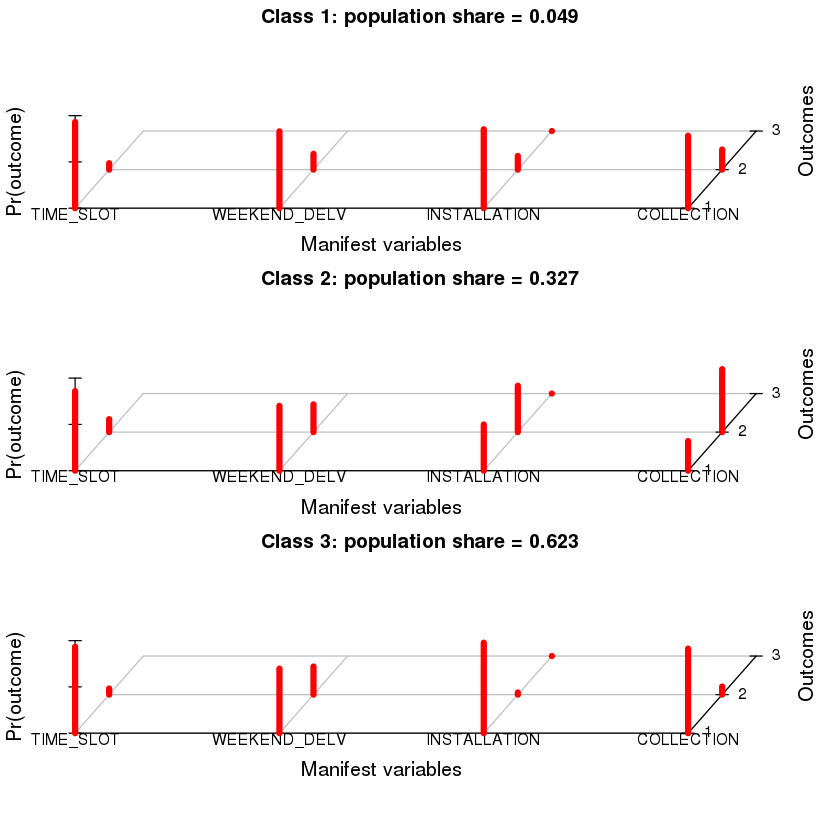

In [47]:
# Experiment with covariate 
lc.with.cov3 <- poLCA(f.csc, data_2020_latent, nclass=3, maxiter=3000, 
                tol=1e-5, graph=TRUE,
                nrep=10, verbose=TRUE, calc.se=TRUE)

save(lc.with.cov3, file = "lc.with.cov3.rda")

In [26]:
data_2020$LATENT <- lc.no.cov3$predclass

In [48]:
data.2020.class1 <- data_2020 %>% filter(LATENT == 1)
data.2020.class2 <- data_2020 %>% filter(LATENT == 2)
data.2020.class3 <- data_2020 %>% filter(LATENT == 3)

> Merchandise areas

In [49]:
class1.ma <- data.2020.class1 %>% group_by(MA) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(MA, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent merchandise areas in class 1",
                                         y = "Frequency (count)",
                                         x = "MA") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



In [50]:
class2.ma <- data.2020.class2 %>% group_by(MA) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(MA, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent merchandise areas in class 2",
                                         y = "Frequency (count)",
                                         x = "MA") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



In [51]:
class3.ma <- data.2020.class3 %>% group_by(MA) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(MA, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent merchandise areas in class 3",
                                         y = "Frequency (count)",
                                         x = "MA") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



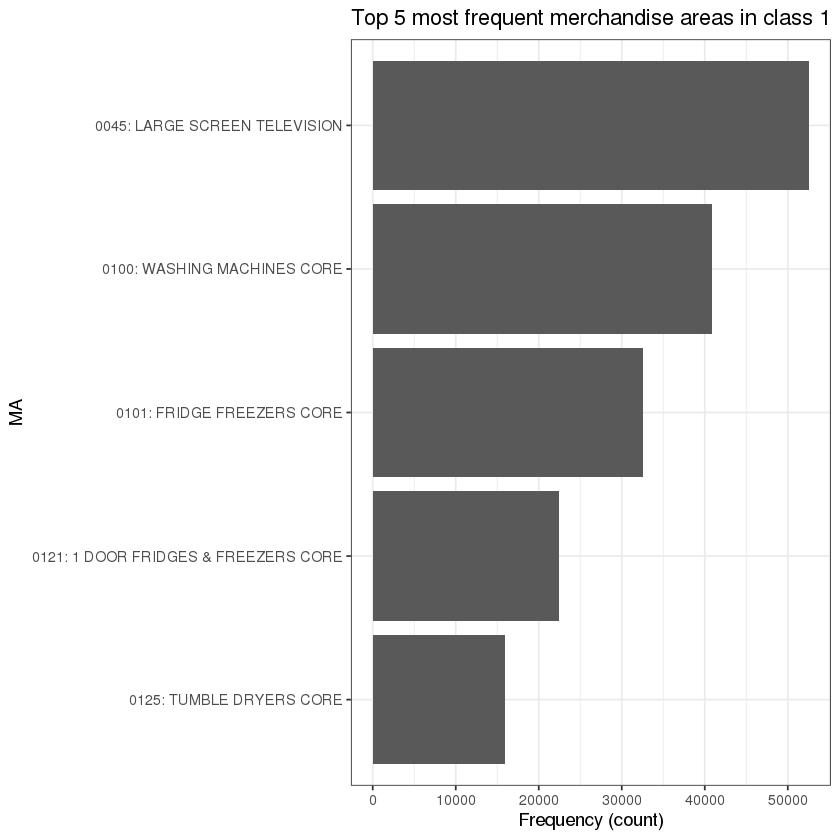

In [52]:
class1.ma
class2.ma
class3.ma

Class 3, which sees the highest propotions of installation and collection services, is topped by washing machine core MA at nearly 3 times higher frequency than the second MA (Cooking standing core). This suggests that customers purchasing washing machines are more likely to acquire installation/disposal services. On the other hand, class 1 with the lowest probability to add any services, entails the highest frequency of screen television. This MA probably would require less professional help to handle.

> Customer segment

In [53]:
class1.cusseg <- data.2020.class1 %>% filter(CUSTOMER_SEGMENT %in% c(1,2,3,4,5,6,7)) %>%
                                group_by(CUSTOMER_SEGMENT) %>% summarise(total = n()) %>%
                                ggplot(aes(x = reorder(CUSTOMER_SEGMENT, total), y = total)) +
                                geom_col() +
                                labs(title = "Frequency of customer segment in class 1",
                                         y = "Frequency (count)",
                                         x = "Customer segment") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)



In [54]:
class2.cusseg <- data.2020.class2 %>% filter(CUSTOMER_SEGMENT %in% c(1,2,3,4,5,6,7)) %>%
                                group_by(CUSTOMER_SEGMENT) %>% summarise(total = n()) %>%
                                ggplot(aes(x = reorder(CUSTOMER_SEGMENT, total), y = total)) +
                                geom_col() +
                                labs(title = "Frequency of customer segment in class 2",
                                         y = "Frequency (count)",
                                         x = "Customer segment") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)



In [55]:
class3.cusseg <- data.2020.class3 %>% filter(CUSTOMER_SEGMENT %in% c(1,2,3,4,5,6,7)) %>%
                                group_by(CUSTOMER_SEGMENT) %>% summarise(total = n()) %>%
                                ggplot(aes(x = reorder(CUSTOMER_SEGMENT, total), y = total)) +
                                geom_col() +
                                labs(title = "Frequency of customer segment in class 3",
                                         y = "Frequency (count)",
                                         x = "Customer segment") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)



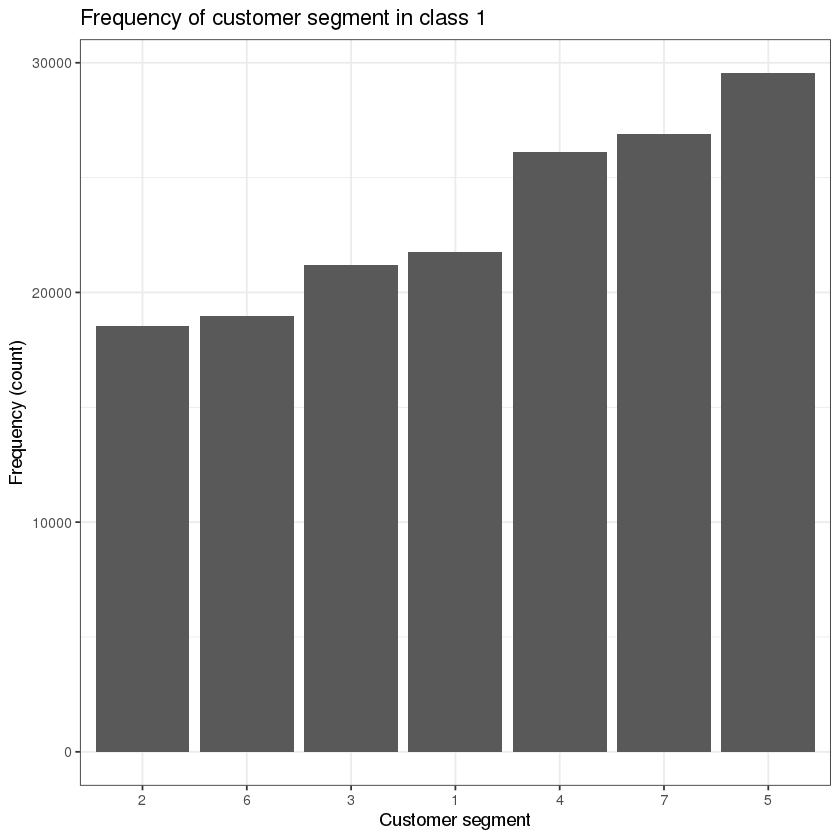

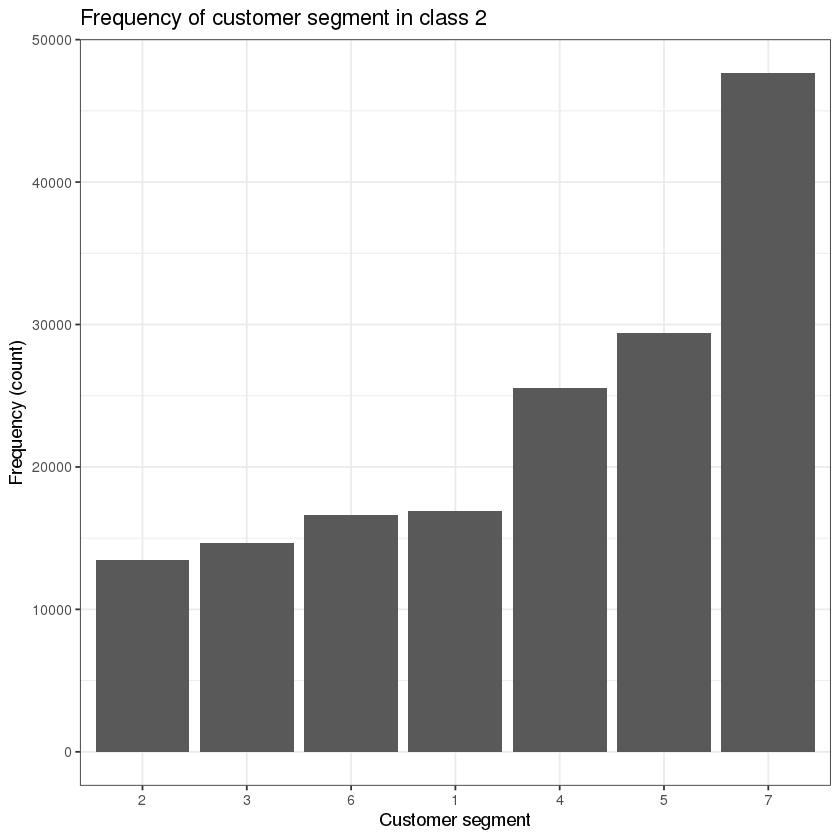

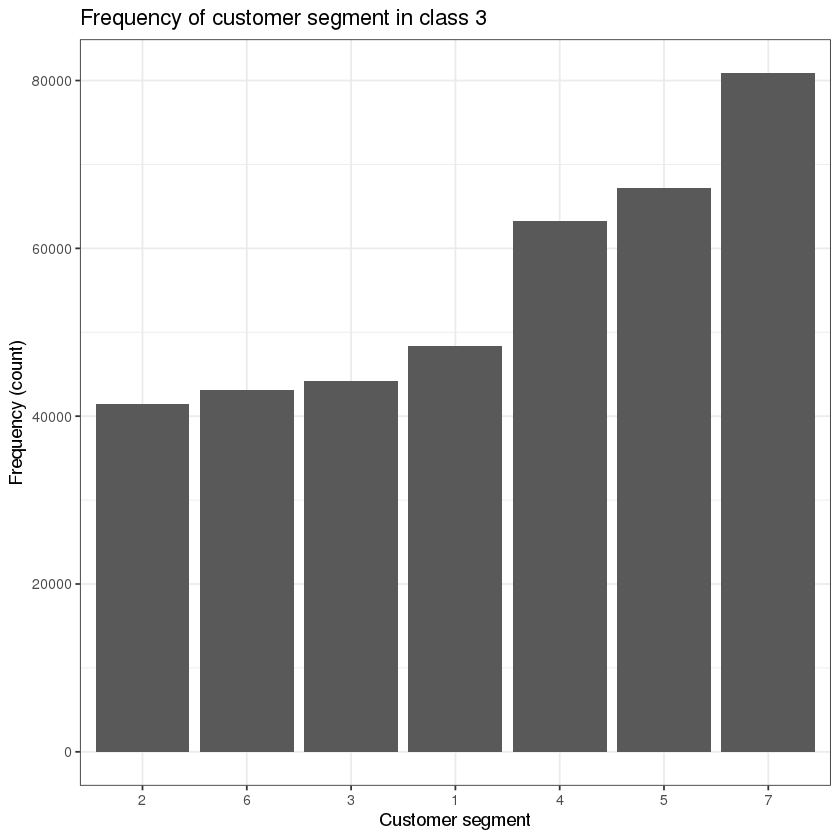

In [56]:
class1.cusseg
class2.cusseg
class3.cusseg

Even though the difference across customer segments in class 2 is marginal, there is a clear gap between the most frequent segment and the second highest segment class 3. For a note, class 3 has a much higher preference for additional services. It could be induced by the fact that the retired (often senior citizens), would require more help with handling the equipment, including both installation and collection/disposal of old appliances. 

> Postal code

In [57]:
class1.pos <- data.2020.class1 %>% group_by(OUTCODE) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(OUTCODE, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent postal codes in class 1",
                                         y = "Frequency (count)",
                                         x = "Postal code") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



In [58]:
class2.pos <- data.2020.class2 %>% group_by(OUTCODE) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(OUTCODE, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent postal codes in class 2",
                                         y = "Frequency (count)",
                                         x = "Postal code") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



In [59]:
class3.pos <- data.2020.class3 %>% group_by(OUTCODE) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(5) %>%
                                ggplot(aes(x = reorder(OUTCODE, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 5 most frequent postal codes in class 3",
                                         y = "Frequency (count)",
                                         x = "Postal code") +
                                theme_bw()

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



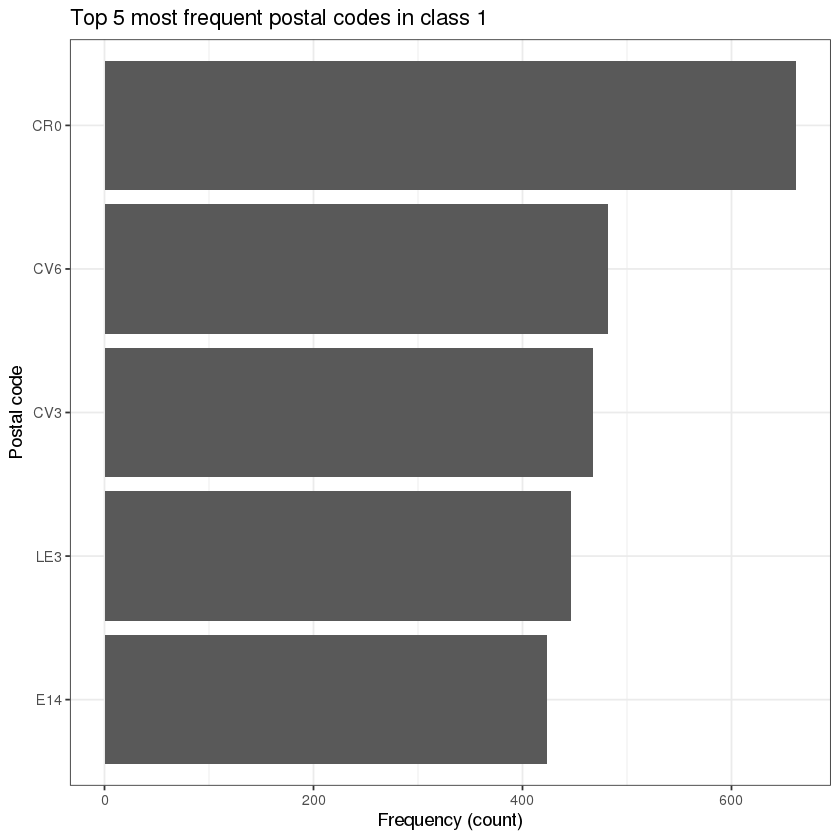

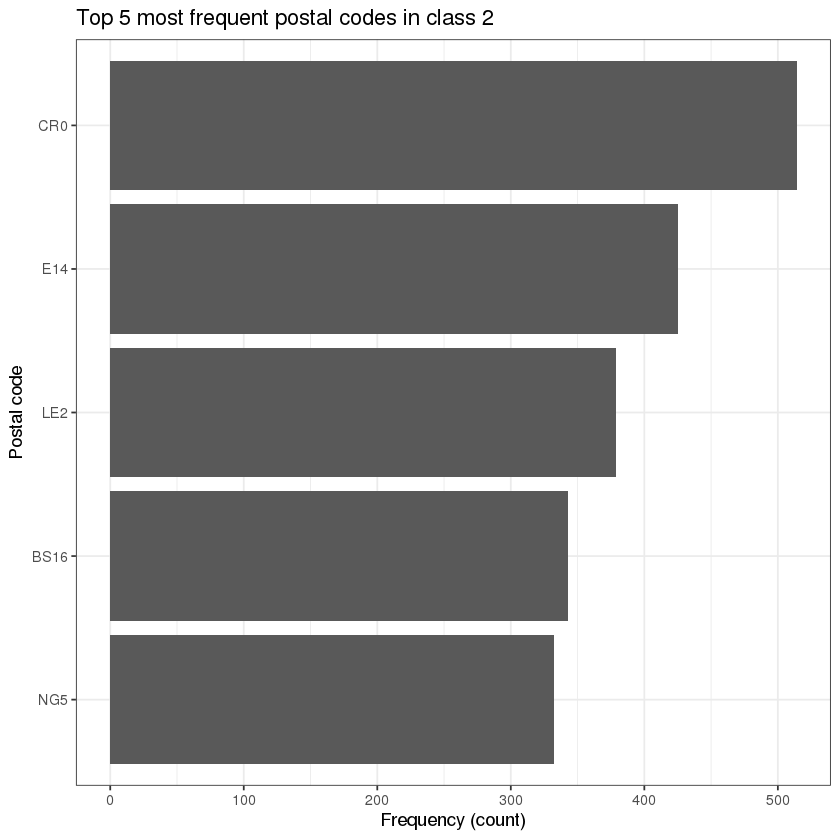

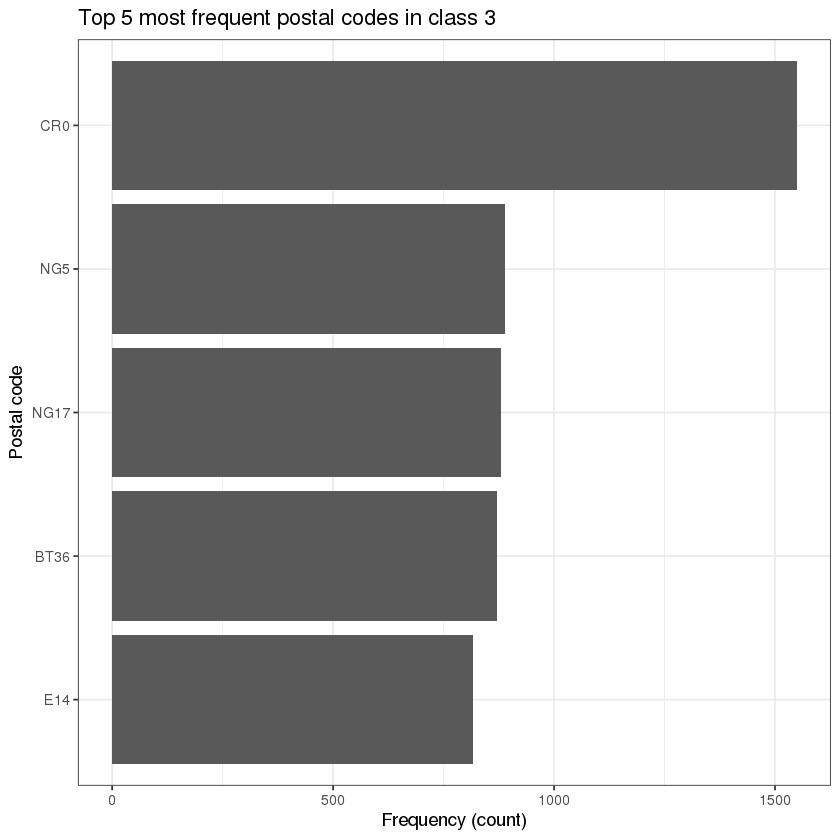

In [60]:
class1.pos
class2.pos
class3.pos

Class 3 which demonstrates higher preferences for time-slot deliveries, contains a much higher proportion of CR0 code.

# Sensitivity analysis

> All data

In [61]:
# Function identifying customer choices
case_choice <- function(extra_op, nextday, timeslot) {
  case_when(
    extra_op == 0 & nextday == 1 & timeslot == 0 ~ "NDO",
    extra_op >= 1 & nextday == 1 & timeslot == 0 ~ "NDE",
    extra_op >= 1 & nextday == 1 & timeslot == 1 ~ "NES",
    extra_op == 0 & nextday == 0 & timeslot == 0 ~ "SO",
    extra_op >= 1 & nextday == 0 & timeslot == 1 ~ "SES",
    TRUE                                         ~ "SE"
  )
}

#NDO: Next day delivery only
#NDE: Next day delivery with extra options
#NES: Next day delivery, with options and time slot
#SO: Standard delivery only
#SE: Standard delivery with extra options
#SES: Standard delivery, with options and time slot

In [62]:
data_2020 <-  data_2020 %>%
              mutate(CHOICE = case_choice(DELV_EXTRA, NEXT_DAY, TIME_SLOT))

In [63]:
data_2020 %>% group_by(CHOICE) %>% summarise(MIN = min(DELIVERY_CHARGE),
                                             MAX = max(DELIVERY_CHARGE))

`summarise()` ungrouping output (override with `.groups` argument)



CHOICE MIN MAX  
1 NDE    0   240.0
2 NDO    0   155.0
3 NES    0   255.0
4 SE     0   375.0
5 SES    0   352.5
6 SO     0   260.0

In [65]:
# Filter all extra options with charges equal to 0, as they are quite likely to be the special offers

data_2020_to_filtered <- which(data_2020$CHOICE %in% c("NDE","NDO","NES","SE","SES") &
                               data_2020$DELIVERY_CHARGE<0.01)

data_2020_filtered <- data_2020[-data_2020_to_filtered, ]
nrow(data_2020_filtered)

[1] 955832

In [66]:
data_2020_filtered %>% group_by(CHOICE) %>% summarise(MIN = min(DELIVERY_CHARGE),
                                                      MAX = max(DELIVERY_CHARGE))

`summarise()` ungrouping output (override with `.groups` argument)



CHOICE MIN   MAX  
1 NDE    0.010 240.0
2 NDO    0.010 155.0
3 NES    0.255 255.0
4 SE     0.010 375.0
5 SES    0.020 352.5
6 SO     0.000 260.0

In [67]:
colnames(data_2020_filtered)

[1] "MA_CODE"          "MA"               "PROD_CD"          "PRODUCT_DESC"    
 [5] "BRAND"            "PLU_RETAIL_PRICE" "BAND_FIFTY"       "CREDIT_BAND"     
 [9] "ORDER_STORE"      "ORDER_DATE"       "DELIVERY_DATE"    "OUTCODE"         
[13] "DLC"              "CSC"              "SRV_TYPS"         "VOLUME"          
[17] "DELIVERY_CHARGE"  "CUSTOMER_SEGMENT" "DATE_DIFF"        "WEEK_DAY"        
[21] "MONTH"            "INSTALLATION"     "COLLECTION"       "TIME_SLOT"       
[25] "WEEKEND_DELV"     "NEXT_DAY"         "DELV_EXTRA"       "ID"              
[29] "CHOICE"           "LATENT"

> Analysis on segment level

In [68]:
# Create new variable: Month of the order placement

data_2020_nomial <- data_2020_filtered %>% 
                    mutate(CHOICE_FACTOR = as.factor(data_2020_filtered$CHOICE))

In [69]:
data.mnl.class1 <- data_2020_nomial %>% filter(LATENT == 1)
data.mnl.class2 <- data_2020_nomial %>% filter(LATENT == 2)
data.mnl.class3 <- data_2020_nomial %>% filter(LATENT == 3)

In [70]:
# Calculatinng average delivery charges and lead time for each OUTCODE in each MONTH 
# (as per confirmed information, only available options for the input postal code will be displayed)

fill.data <- data_2020_nomial %>%
             group_by(OUTCODE, MONTH, CHOICE) %>%
             summarise(AVG_CHARGE = mean(DELIVERY_CHARGE),
                       AVG_TIME = mean(DATE_DIFF))

`summarise()` regrouping output by 'OUTCODE', 'MONTH' (override with `.groups` argument)



In [71]:
standard.fill       <- fill.data %>% filter(CHOICE == "SO")
standard.extra.fill <- fill.data %>% filter(CHOICE == "SE")
standard.slot.fill  <- fill.data %>% filter(CHOICE == "SES")
next.fill           <- fill.data %>% filter(CHOICE == "NDO")
next.extra.fill     <- fill.data %>% filter(CHOICE == "NDE")
next.slot.fill      <- fill.data %>% filter(CHOICE == "NES")

> Segment 1

In [72]:
unique(data.mnl.class1$CHOICE)

[1] "SO"  "SE"  "NDO" "NDE"

In [73]:
data.mnl.class1.wide <- data.mnl.class1 %>% spread(CHOICE, DELIVERY_CHARGE)

In [74]:
# As exact values offered at the time of selection are not recorded, I would use average values as substitutes

data.mnl.class1.wide1 <- left_join(data.mnl.class1.wide, standard.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SO", "AVG_TIME" = "TIME.SO"))

data.mnl.class1.wide2 <- left_join(data.mnl.class1.wide1, standard.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SE", "AVG_TIME" = "TIME.SE"))

data.mnl.class1.wide3 <- left_join(data.mnl.class1.wide2, next.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NDO", "AVG_TIME" = "TIME.NDO"))
                                      
data.mnl.class1.wide4 <- left_join(data.mnl.class1.wide3, next.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NDE", "AVG_TIME" = "TIME.NDE"))

In [75]:
# Fill in actual values for selected options
# Standard_only 
data.mnl.class1.wide4$CHARGE.SO <- ifelse(is.na(data.mnl.class1.wide4$SO), data.mnl.class1.wide4$CHARGE.SO,
                                                     data.mnl.class1.wide4$SO)
data.mnl.class1.wide4$TIME.SO <- ifelse(is.na(data.mnl.class1.wide4$SO), data.mnl.class1.wide4$TIME.SO,
                                                     data.mnl.class1.wide4$DATE_DIFF)

#Standard extra
data.mnl.class1.wide4$CHARGE.SE <- ifelse(is.na(data.mnl.class1.wide4$SE), data.mnl.class1.wide4$CHARGE.SE,
                                                     data.mnl.class1.wide4$SE)
data.mnl.class1.wide4$TIME.SE <- ifelse(is.na(data.mnl.class1.wide4$SE), data.mnl.class1.wide4$TIME.SE,
                                                     data.mnl.class1.wide4$DATE_DIFF)

#Next day only
data.mnl.class1.wide4$CHARGE.NDO <- ifelse(is.na(data.mnl.class1.wide4$NDO), data.mnl.class1.wide4$CHARGE.NDO,
                                                     data.mnl.class1.wide4$NDO)
data.mnl.class1.wide4$TIME.NDO <- ifelse(is.na(data.mnl.class1.wide4$NDO), data.mnl.class1.wide4$TIME.NDO,
                                                     data.mnl.class1.wide4$DATE_DIFF)

#Next day extra
data.mnl.class1.wide4$CHARGE.NDE <- ifelse(is.na(data.mnl.class1.wide4$NDE), data.mnl.class1.wide4$CHARGE.NDE,
                                                     data.mnl.class1.wide4$NDE)
data.mnl.class1.wide4$TIME.NDE <- ifelse(is.na(data.mnl.class1.wide4$NDE), data.mnl.class1.wide4$TIME.NDE,
                                                     data.mnl.class1.wide4$DATE_DIFF)

In [76]:
data.mnl.class1.fin <- data.mnl.class1.wide4 %>% select(CHOICE_FACTOR,CHARGE.SO,TIME.SO,
                                                        CHARGE.SE,TIME.SE,
                                                        CHARGE.NDO,TIME.NDO,
                                                        CHARGE.NDE,TIME.NDE,PLU_RETAIL_PRICE) %>%
                                                        drop_na()
#data.mnl.class1.fin$CHOICEID <- 1:nrow(data.mnl.class1.fin)
data.mnl.class1.fin <- as.data.frame(gdata::drop.levels(data.mnl.class1.fin))
head(data.mnl.class1.fin)

CHOICE_FACTOR CHARGE.SO TIME.SO CHARGE.SE TIME.SE  CHARGE.NDO TIME.NDO
1 SO             0         3      29.02778  4.444444 18.45588   1       
2 SO             0         5      34.37650  6.153846 14.00000   1       
3 SO             0        10      37.00000  5.400000 15.00000   1       
4 SO             0         7      24.34211  7.052632 25.00000   1       
5 SO            10        11      41.08511  5.638298 23.33333   1       
6 SO             0         7      52.57576  5.636364 33.75000   1       
  CHARGE.NDE TIME.NDE PLU_RETAIL_PRICE
1 40.76923   1          39.99         
2 42.72727   1          49.99         
3 42.50000   1        1419.00         
4 40.00000   1          49.99         
5 65.00000   1        1429.00         
6 41.66667   1        1799.00

In [77]:
# Regression data for class 1:

MNL1_data <- mlogit.data(data=data.mnl.class1.fin, shape = "wide",
                         varying = 2:9, choice = "CHOICE_FACTOR")

In [78]:
head(MNL1_data, 4)

~~~~~~~
 first 4 observations out of 721468 
~~~~~~~
  CHOICE_FACTOR PLU_RETAIL_PRICE alt   CHARGE     TIME chid   idx
1         FALSE            39.99 NDE 40.76923 1.000000    1 1:NDE
2         FALSE            39.99 NDO 18.45588 1.000000    1 1:NDO
3         FALSE            39.99  SE 29.02778 4.444444    1  1:SE
4          TRUE            39.99  SO  0.00000 3.000000    1  1:SO

~~~ indexes ~~~~
  chid alt
1    1 NDE
2    1 NDO
3    1  SE
4    1  SO
indexes:  1, 2 


In [79]:
# Multinomial logit

mnl.class1 <- mlogit(CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE,
                     data = MNL1_data)
summary(mnl.class1)


Call:
mlogit(formula = CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE, 
    data = MNL1_data, method = "nr")

Frequencies of alternatives:choice
     NDE      NDO       SE       SO 
0.035372 0.086252 0.214352 0.664024 

nr method
6 iterations, 0h:0m:19s 
g'(-H)^-1g = 0.000173 
successive function values within tolerance limits 

Coefficients :
                        Estimate  Std. Error   z-value  Pr(>|z|)    
(Intercept):NDO      -9.4596e-01  2.7751e-02  -34.0877 < 2.2e-16 ***
(Intercept):SE        1.5495e+00  2.6057e-02   59.4664 < 2.2e-16 ***
(Intercept):SO        5.9687e-01  2.8688e-02   20.8059 < 2.2e-16 ***
CHARGE               -6.7115e-02  4.3827e-04 -153.1374 < 2.2e-16 ***
TIME                 -1.0699e-01  1.7065e-03  -62.6960 < 2.2e-16 ***
PLU_RETAIL_PRICE:NDO  7.6576e-04  5.8005e-05   13.2017 < 2.2e-16 ***
PLU_RETAIL_PRICE:SE   1.6107e-04  5.7504e-05    2.8010  0.005094 ** 
PLU_RETAIL_PRICE:SO   4.7793e-04  5.4574e-05    8.7574 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.

In [80]:
# Marginal effects of delivery charge
effects(mnl.class1, covariate = "CHARGE", type = "rr")

NDE        NDO        SE         SO        
NDE -3.1951821  0.0891740  0.0891740  0.0891740
NDO  0.1260835 -1.3858528  0.1260835  0.1260835
SE   0.4767593  0.4767593 -1.9723642  0.4767593
SO   0.2260898  0.2260898  0.2260898 -0.0993169

Class 1 customers show a strong sensitivity towards prices, as changes in the cheaper options (SE and SO) will lead to much higher increases in probabilities for other options, whilst changes in more expensive options (NDE and NDO) only affect probabilities for other options marginally.

In [81]:
coef(mnl.class1)[5]/coef(mnl.class1)[4]

TIME 
1.594106

The lead time is valued at 75p to access a higher-ranked option

In [82]:
# Marginal effects of purchased item's price
effects(mnl.class1, covariate = "PLU_RETAIL_PRICE", type = "ar")

NDE          NDO           SE           SO 
-0.004479331  0.010898916 -0.020008930  0.013589352

A 100% increase in terms of purchased item price will increase the probabilities of choosing delivery only (0.8% for next-day and 0.9% for standard deliveries) and reduce the probabilities of adding other services.

> Segment 2

In [83]:
unique(data.mnl.class2$CHOICE)

[1] "SE"  "NDE" "SES" "NES"

In [84]:
data.mnl.class2.wide <- data.mnl.class2 %>% spread(CHOICE, DELIVERY_CHARGE)

In [85]:
# Joining average data

data.mnl.class2.wide1 <- left_join(data.mnl.class2.wide, standard.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SE", "AVG_TIME" = "TIME.SE"))

data.mnl.class2.wide2 <- left_join(data.mnl.class2.wide1, next.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NDE", "AVG_TIME" = "TIME.NDE"))

data.mnl.class2.wide3 <- left_join(data.mnl.class2.wide2, standard.slot.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SES", "AVG_TIME" = "TIME.SES"))
                                      
data.mnl.class2.wide4 <- left_join(data.mnl.class2.wide3, next.slot.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NES", "AVG_TIME" = "TIME.NES"))

In [86]:
# Fill in actual values for selected options
# Standard extra
data.mnl.class2.wide4$CHARGE.SE <- ifelse(is.na(data.mnl.class2.wide4$SE), data.mnl.class2.wide4$CHARGE.SE,
                                                     data.mnl.class2.wide4$SE)
data.mnl.class2.wide4$TIME.SE <- ifelse(is.na(data.mnl.class2.wide4$SE), data.mnl.class2.wide4$TIME.SE,
                                                     data.mnl.class2.wide4$DATE_DIFF)

#Next day extra
data.mnl.class2.wide4$CHARGE.NDE <- ifelse(is.na(data.mnl.class2.wide4$NDE), data.mnl.class2.wide4$CHARGE.NDE,
                                                     data.mnl.class2.wide4$NDE)
data.mnl.class2.wide4$TIME.NDE <- ifelse(is.na(data.mnl.class2.wide4$NDE), data.mnl.class2.wide4$TIME.NDE,
                                                     data.mnl.class2.wide4$DATE_DIFF)

#Standard extra slot
data.mnl.class2.wide4$CHARGE.SES <- ifelse(is.na(data.mnl.class2.wide4$SES), data.mnl.class2.wide4$CHARGE.SES,
                                                     data.mnl.class2.wide4$SES)
data.mnl.class2.wide4$TIME.SES <- ifelse(is.na(data.mnl.class2.wide4$SES), data.mnl.class2.wide4$TIME.SES,
                                                     data.mnl.class2.wide4$DATE_DIFF)

#Next day extra slot
data.mnl.class2.wide4$CHARGE.NES <- ifelse(is.na(data.mnl.class2.wide4$NES), data.mnl.class2.wide4$CHARGE.NES,
                                                     data.mnl.class2.wide4$NES)
data.mnl.class2.wide4$TIME.NES <- ifelse(is.na(data.mnl.class2.wide4$NES), data.mnl.class2.wide4$TIME.NES,
                                                     data.mnl.class2.wide4$DATE_DIFF)

In [87]:
data.mnl.class2.fin <- data.mnl.class2.wide4 %>% select(CHOICE_FACTOR,CHARGE.SE,TIME.SE,
                                                        CHARGE.SES,TIME.SES,
                                                        CHARGE.NDE,TIME.NDE,
                                                        CHARGE.NES,TIME.NES,PLU_RETAIL_PRICE) %>%
                                                        drop_na()

data.mnl.class2.fin <- as.data.frame(gdata::drop.levels(data.mnl.class2.fin))
head(data.mnl.class2.fin)

CHOICE_FACTOR CHARGE.SE TIME.SE   CHARGE.SES TIME.SES CHARGE.NDE TIME.NDE
1 SE             10.00000  2.000000 28.33333   6.333333  40.83333  1       
2 SE             45.00000 10.000000 63.12500   4.000000  38.75000  1       
3 SE             90.00000  8.000000 51.42857   4.428571  58.57143  1       
4 SE            130.00000 25.000000 57.27174   4.652174  52.22222  1       
5 NDE            43.14773  5.931818 45.95238   7.142857 105.00000  1       
6 SE             55.00000  8.000000 70.50000   3.750000  44.72222  1       
  CHARGE.NES TIME.NES PLU_RETAIL_PRICE
1  65.00000  1          39.99         
2  95.00000  1          39.99         
3  76.75000  1        1622.00         
4  51.66667  1        1579.00         
5  70.00000  1        1905.00         
6 100.00000  1          49.99

In [88]:
# Regression data for class 3:

MNL2_data <- mlogit.data(data=data.mnl.class2.fin, shape = "wide",
                         varying = 2:9, choice = "CHOICE_FACTOR")

In [89]:
mnl.class2 <- mlogit(CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE,
                     data = MNL2_data)
summary(mnl.class2)


Call:
mlogit(formula = CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE, 
    data = MNL2_data, method = "nr")

Frequencies of alternatives:choice
     NDE      NES       SE      SES 
0.064351 0.058514 0.697498 0.179637 

nr method
6 iterations, 0h:0m:9s 
g'(-H)^-1g = 1.39E-05 
successive function values within tolerance limits 

Coefficients :
                        Estimate  Std. Error  z-value  Pr(>|z|)    
(Intercept):NES      -3.5025e-01  2.9730e-02 -11.7810 < 2.2e-16 ***
(Intercept):SE        2.4273e+00  2.3368e-02 103.8725 < 2.2e-16 ***
(Intercept):SES       8.0276e-01  2.5648e-02  31.2987 < 2.2e-16 ***
CHARGE                1.6010e-02  2.1793e-04  73.4643 < 2.2e-16 ***
TIME                  2.2710e-02  1.9558e-03  11.6118 < 2.2e-16 ***
PLU_RETAIL_PRICE:NES -4.6600e-05  5.8228e-05  -0.8003  0.423534    
PLU_RETAIL_PRICE:SE  -2.8015e-04  4.2178e-05  -6.6421 3.093e-11 ***
PLU_RETAIL_PRICE:SES -1.5008e-04  4.7383e-05  -3.1674  0.001538 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0

In [90]:
# Marginal effects of delivery charge
effects(mnl.class2, covariate = "CHARGE", type = "rr")

NDE         NES         SE          SES        
NDE  0.76953413 -0.05078583 -0.05078583 -0.05078583
NES -0.05688095  0.99570539 -0.05688095 -0.05688095
SE  -0.59116633 -0.59116633  0.23805276 -0.59116633
SES -0.16838923 -0.16838923 -0.16838923  0.81558561

In [91]:
coef(mnl.class2)[5]/coef(mnl.class2)[4]

TIME 
1.418469

In [92]:
# Marginal effects of purchased item's price
effects(mnl.class2, covariate = "PLU_RETAIL_PRICE", type = "ar")

NDE          NES           SE          SES 
 0.005445740  0.003781577 -0.014368669  0.005141357

> Segment 3

In [93]:
unique(data.mnl.class3$CHOICE)

[1] "SO"  "NDO" "SE"  "NDE"

In [94]:
data.mnl.class3.wide <- data.mnl.class3 %>% spread(CHOICE, DELIVERY_CHARGE)

In [95]:
# Joining average data

data.mnl.class3.wide1 <- left_join(data.mnl.class3.wide, standard.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SE", "AVG_TIME" = "TIME.SE"))

data.mnl.class3.wide2 <- left_join(data.mnl.class3.wide1, next.extra.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NDE", "AVG_TIME" = "TIME.NDE"))

data.mnl.class3.wide3 <- left_join(data.mnl.class3.wide2, standard.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.SO", "AVG_TIME" = "TIME.SO"))
                                      
data.mnl.class3.wide4 <- left_join(data.mnl.class3.wide3, next.fill, by = c("OUTCODE", "MONTH")) %>%
                         plyr::rename(c("AVG_CHARGE" = "CHARGE.NDO", "AVG_TIME" = "TIME.NDO"))

In [96]:
# Fill in actual values for selected options
# Standard extra
data.mnl.class3.wide4$CHARGE.SE <- ifelse(is.na(data.mnl.class3.wide4$SE), data.mnl.class3.wide4$CHARGE.SE,
                                                     data.mnl.class3.wide4$SE)
data.mnl.class3.wide4$TIME.SE <- ifelse(is.na(data.mnl.class3.wide4$SE), data.mnl.class3.wide4$TIME.SE,
                                                     data.mnl.class3.wide4$DATE_DIFF)

#Next day extra
data.mnl.class3.wide4$CHARGE.NDE <- ifelse(is.na(data.mnl.class3.wide4$NDE), data.mnl.class3.wide4$CHARGE.NDE,
                                                     data.mnl.class3.wide4$NDE)
data.mnl.class3.wide4$TIME.NDE <- ifelse(is.na(data.mnl.class3.wide4$NDE), data.mnl.class3.wide4$TIME.NDE,
                                                     data.mnl.class3.wide4$DATE_DIFF)

#Standard extra slot
data.mnl.class3.wide4$CHARGE.SO <- ifelse(is.na(data.mnl.class3.wide4$SO), data.mnl.class3.wide4$CHARGE.SO,
                                                     data.mnl.class3.wide4$SO)
data.mnl.class3.wide4$TIME.SO <- ifelse(is.na(data.mnl.class3.wide4$SO), data.mnl.class3.wide4$TIME.SO,
                                                     data.mnl.class3.wide4$DATE_DIFF)

#Next day extra slot
data.mnl.class3.wide4$CHARGE.NDO <- ifelse(is.na(data.mnl.class3.wide4$NDO), data.mnl.class3.wide4$CHARGE.NDO,
                                                     data.mnl.class3.wide4$NDO)
data.mnl.class3.wide4$TIME.NDO <- ifelse(is.na(data.mnl.class3.wide4$NDO), data.mnl.class3.wide4$TIME.NDO,
                                                     data.mnl.class3.wide4$DATE_DIFF)

In [97]:
data.mnl.class3.fin <- data.mnl.class3.wide4 %>% select(CHOICE_FACTOR,CHARGE.SE,TIME.SE,
                                                        CHARGE.SO,TIME.SO,
                                                        CHARGE.NDE,TIME.NDE,
                                                        CHARGE.NDO,TIME.NDO,PLU_RETAIL_PRICE) %>%
                                                        drop_na()

data.mnl.class3.fin <- as.data.frame(gdata::drop.levels(data.mnl.class3.fin))
head(data.mnl.class3.fin)

CHOICE_FACTOR CHARGE.SE TIME.SE  CHARGE.SO TIME.SO  CHARGE.NDE TIME.NDE
1 SO            43.75000  5.125000  0.000000 9.000000 47.85714   1       
2 NDO           30.68966  4.586207  7.277778 4.966667 46.00000   1       
3 SO            30.90000  5.380000  0.000000 4.000000 50.00000   1       
4 SO            51.36625  6.285714  2.000000 6.000000 25.62500   1       
5 SO            42.47111  6.047619 30.000000 3.000000 50.00000   1       
6 SO            31.95312  4.187500  0.000000 5.000000 41.25000   1       
  CHARGE.NDO TIME.NDO PLU_RETAIL_PRICE
1 34.44444   1          49.99         
2 30.00000   1        1899.00         
3 23.33333   1          49.99         
4 20.00000   1          39.99         
5 20.00000   1        2029.00         
6 22.25839   1          39.99

In [98]:
# Regression data for class 3:

MNL3_data <- mlogit.data(data=data.mnl.class3.fin, shape = "wide",
                         varying = 2:9, choice = "CHOICE_FACTOR")

In [99]:
mnl.class3 <- mlogit(CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE,
                     data = MNL3_data)
summary(mnl.class3)


Call:
mlogit(formula = CHOICE_FACTOR ~ CHARGE + TIME | PLU_RETAIL_PRICE, 
    data = MNL3_data, method = "nr")

Frequencies of alternatives:choice
     NDE      NDO       SE       SO 
0.028194 0.068936 0.210812 0.692058 

nr method
6 iterations, 0h:0m:39s 
g'(-H)^-1g = 0.00248 
successive function values within tolerance limits 

Coefficients :
                        Estimate  Std. Error   z-value Pr(>|z|)    
(Intercept):NDO      -1.1386e+00  2.0042e-02  -56.8075  < 2e-16 ***
(Intercept):SE        1.5372e+00  1.8568e-02   82.7863  < 2e-16 ***
(Intercept):SO        1.7075e-01  2.0302e-02    8.4106  < 2e-16 ***
CHARGE               -8.3717e-02  3.0997e-04 -270.0778  < 2e-16 ***
TIME                 -7.6190e-02  1.1025e-03  -69.1060  < 2e-16 ***
PLU_RETAIL_PRICE:NDO  5.2255e-04  4.3040e-05   12.1411  < 2e-16 ***
PLU_RETAIL_PRICE:SE   7.3541e-05  4.1622e-05    1.7669  0.07725 .  
PLU_RETAIL_PRICE:SO   4.2459e-04  3.9682e-05   10.6997  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0

In [100]:
# Marginal effects of delivery charge
effects(mnl.class3, covariate = "CHARGE", type = "rr")

NDE        NDO         SE          SO         
NDE -3.9920153  0.07564219  0.07564219  0.07564219
NDO  0.1219902 -1.74555147  0.12199020  0.12199020
SE   0.5447640  0.54476404 -2.47449830  0.54476404
SO   0.2589541  0.25895410  0.25895410 -0.09305157

The results show that customers in class 3 are less sentitive to delivery fees, as changes in CHARGE do not increase the probabilities of choosing other options.

In [101]:
coef(mnl.class3)[5]/coef(mnl.class3)[4]

TIME 
0.9100866

Class 3, in which customers are more convenience-oriented (with higher probabilities of choosing delivery within time windows and addtional services), values time at double as high as class 1.

In [102]:
# Marginal effects of purchased item's price
effects(mnl.class3, covariate = "PLU_RETAIL_PRICE", type = "ar")

NDE          NDO           SE           SO 
-0.002493988  0.003964413 -0.019251519  0.017781092

In general, increases in class 3's retail prices will raise the probabilities of choosing value-added delivery options

In [103]:
stargazer::stargazer(mnl.class1, mnl.class2, mnl.class3, type = "text")


                               Dependent variable:           
                     ----------------------------------------
                                  CHOICE_FACTOR              
                          (1)          (2)           (3)     
-------------------------------------------------------------
(Intercept):NDO        -0.946***                  -1.139***  
                        (0.028)                    (0.020)   
                                                             
(Intercept):NES                     -0.350***                
                                     (0.030)                 
                                                             
(Intercept):SE         1.550***      2.427***     1.537***   
                        (0.026)      (0.023)       (0.019)   
                                                             
(Intercept):SO         0.597***                   0.171***   
                        (0.029)                    (0.020)   
       

In [104]:
data_2020$LATENT <- as.factor(data_2020$LATENT)
charge.aov <- aov(DELIVERY_CHARGE ~ LATENT, data = data_2020)
summary(charge.aov)

                 Df    Sum Sq   Mean Sq F value Pr(>F)    
LATENT            2 335027693 167513846  463617 <2e-16 ***
Residuals   1002075 362068968       361                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [108]:
choice.data <- data.frame(Class_1 = table(data.mnl.class1$CHOICE_FACTOR),
                          Class_2 = table(data.mnl.class2$CHOICE_FACTOR),
                          Class_3 = table(data.mnl.class3$CHOICE_FACTOR))

In [109]:
choice.data

Class_1.Var1 Class_1.Freq Class_2.Var1 Class_2.Freq Class_3.Var1 Class_3.Freq
1 NDE            6859       NDE           10844       NDE           12362      
2 NDO           17520       NDO               0       NDO           31949      
3 NES               0       NES            7027       NES               0      
4 SE            48788       SE           140607       SE           112441      
5 SES               0       SES           35166       SES               0      
6 SO           153166       SO                0       SO           379103